In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Ensure ticker is imported
import scipy.interpolate as interp  # Import scipy for interpolation

# Configure global font settings for consistency
plt.rcParams.update({
    'font.size': 14,               # Base font size
    'axes.titlesize': 14,          # Font size for titles
    'axes.labelsize': 14,          # Font size for axis labels
    'xtick.labelsize': 14,         # Font size for x-tick labels
    'ytick.labelsize': 14,         # Font size for y-tick labels
    'legend.fontsize': 14,         # Font size for legends
})

def set_tick_format(ax, cbar=None, decimals=2):
    """Set consistent tick formatting for axes and colorbar."""
    formatter = ticker.FormatStrFormatter(f'%.{decimals}f')
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    if cbar is not None:
        cbar.ax.yaxis.set_major_formatter(formatter)

def convert_masked_to_numpy(arr):
    """Convert masked arrays to regular numpy arrays."""
    if isinstance(arr, np.ma.MaskedArray):
        return arr.filled(np.nan)
    return np.array(arr)

def create_regular_grid(x, y):
    """Create a regular grid from x and y coordinates."""
    x_unique = np.unique(x)
    y_unique = np.unique(y)
    X, Y = np.meshgrid(x_unique, y_unique)
    return X, Y, x_unique, y_unique

def interpolate_to_fvm_grid(data, source_mesh, target_mesh, interp_func='linear'):
    """
    Interpolate data from source mesh to target mesh.
    
    Parameters:
    - data: 2D numpy array of values
    - source_mesh: Tuple of (x, y) arrays defining the source grid
    - target_mesh: Tuple of (x, y) arrays defining the target grid
    - interp_func: Interpolation method
    
    Returns:
    - Interpolated values on target mesh
    """
    x_source, y_source = source_mesh
    x_target, y_target = target_mesh
    
    # Create regular grids
    _, _, x_source_unique, y_source_unique = create_regular_grid(x_source, y_source)
    _, _, x_target_unique, y_target_unique = create_regular_grid(x_target, y_target)
    
    # Reshape data if necessary
    if data.shape != (len(y_source_unique), len(x_source_unique)):
        data = data.reshape(len(y_source_unique), len(x_source_unique))
    
    # Create interpolator
    interpolator = interp.RegularGridInterpolator(
        (y_source_unique, x_source_unique),
        data,
        method=interp_func,
        bounds_error=False,
        fill_value=np.nan
    )
    
    # Create points for interpolation
    XX, YY = np.meshgrid(x_target_unique, y_target_unique)
    points = np.column_stack((YY.ravel(), XX.ravel()))
    
    # Perform interpolation
    interpolated = interpolator(points).reshape(len(y_target_unique), len(x_target_unique))
    
    return interpolated

def calculate_l2_difference(pred, ref, is_pressure=False):
    """Calculate L2 difference between predicted and reference fields."""
    # Ensure arrays are flattened for the calculation
    pred_flat = pred.flatten()
    ref_flat = ref.flatten()
    
    if is_pressure:
        # For pressure, remove mean from both fields before comparing
        pred_flat = pred_flat - np.mean(pred_flat)
        ref_flat = ref_flat - np.mean(ref_flat)
    
    # Calculate L2 norm of the difference divided by L2 norm of reference
    l2_diff = np.sqrt(np.sum((pred_flat - ref_flat)**2))
    l2_ref = np.sqrt(np.sum(ref_flat**2))
    return 100 * (l2_diff / l2_ref) if l2_ref != 0 else float('inf')


def plot_centerline_comparison(pikan_data, spikan_data_1, spikan_data_2, reference_fvm_data, Re, epochs):
    # Reference velocities (Ghia et al., 1982)
    ref_x = np.array([1.00000,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5000,0.2344,0.2266,0.1563,0.0938,0.0781,0.0703,0.0625,0.0000])
    ref_y = np.array([1.0000,0.9766,0.9688,0.9609,0.9531,0.8516,0.7344,0.6172,0.5000,0.4531,0.2813,0.1719,0.1016,0.0703,0.0625,0.0547,0.0000])

    if Re == 100.:
        ref_u = np.array([1.00000,0.84123,0.78871,0.73722,0.68717,0.23151,0.00332,-0.13641,-0.20581,-0.21090,-0.15662,-0.10150,-0.06434,-0.04775,-0.04192,-0.03717,0.00000])
        ref_v = np.array([0.00000,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,-0.22445,-0.24533,0.05454,0.17527,0.17507,0.16077,0.12317,0.10890,0.10091,0.09233,0.00000])
    elif Re == 400.:
        ref_u = np.array([1.00000,0.75837,0.68439,0.61756,0.55892,0.29093,0.16256,0.02135,-0.11477,-0.17119,-0.32726,-0.24299,-0.14612,-0.10338,-0.09266,-0.08186,0.00000])
        ref_v = np.array([0.00000,-0.12146,-0.15663,-0.19254,-0.22847,-0.23827,-0.44993,-0.38598,0.05186,0.30174,0.30203,0.28124,0.22965,0.20920,0.19713,0.18360,0.00000])
    elif Re == 1000.:
        ref_u = np.array([1.00000,0.65928,0.57492,0.51117,0.46604,0.33304,0.18719,0.05702,-0.06080,-0.10648,-0.27805,-0.38289,-0.29730,-0.22220,-0.20196,-0.18109,0.00000])
        ref_v = np.array([0.00000,-0.21388,-0.27669,-0.33714,-0.39188,-0.51500,-0.42665,-0.31966,0.02526,0.32235,0.33075,0.37095,0.32627,0.30353,0.29012,0.27485,0.00000])

    # Extract field variables and mesh for each dataset
    U_p = pikan_data['field_variables']['u']
    V_p = pikan_data['field_variables']['v']
    X_p = pikan_data['mesh']['x_mesh']
    Y_p = pikan_data['mesh']['y_mesh']

    U_s1 = spikan_data_1['field_variables']['u']
    V_s1 = spikan_data_1['field_variables']['v']
    X_s1 = spikan_data_1['mesh']['x_mesh']
    Y_s1 = spikan_data_1['mesh']['y_mesh']

    U_s2 = spikan_data_2['field_variables']['u']
    V_s2 = spikan_data_2['field_variables']['v']
    X_s2 = spikan_data_2['mesh']['x_mesh']
    Y_s2 = spikan_data_2['mesh']['y_mesh']

    # Extract FVM reference data
    X_fvm = reference_fvm_data['mesh']['x_mesh']
    Y_fvm = reference_fvm_data['mesh']['y_mesh']
    U_fvm = reference_fvm_data['field_variables']['u']
    V_fvm = reference_fvm_data['field_variables']['v']

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # x vs v on horizontal centerline (y = L/2)
    centerline_p_y = Y_p.shape[0] // 2
    centerline_s1_y = Y_s1.shape[0] // 2
    centerline_s2_y = Y_s2.shape[0] // 2
    centerline_fvm_y = Y_fvm.shape[0] // 2


    x_p_line = X_p[centerline_p_y, :]
    v_p_line = V_p[centerline_p_y, :]

    x_s1_line = X_s1[centerline_s1_y, :]
    v_s1_line = V_s1[centerline_s1_y, :]

    x_s2_line = X_s2[centerline_s2_y, :]
    v_s2_line = V_s2[centerline_s2_y, :]

    x_fvm_line = X_fvm[centerline_fvm_y, :]
    v_fvm_line = V_fvm[centerline_fvm_y, :]
    

    ax[0].scatter(ref_x, ref_v, color='k', s=30, label='Reference (Ghia et al., 1982)')
    ax[0].plot(x_fvm_line, v_fvm_line, color='purple', linestyle='--', linewidth=2, label='Reference (FVM)')
    ax[0].plot(x_p_line, v_p_line, color='r', linewidth=2, label=r'PIKAN, $n_\text{cp}=50^2$')
    ax[0].plot(x_s1_line, v_s1_line, color='b', linewidth=2, label=r'SPIKAN (a), $n_\text{cp}=50^2$')
    ax[0].plot(x_s2_line, v_s2_line, color='g', linewidth=2, label=r'SPIKAN (b), $n_\text{cp}=100^2$')
    ax[0].set_xlabel(r'$x/L$')
    ax[0].set_ylabel(r'$v/U_0$')
    ax[0].set_title(r'$v$ on Horizontal Centerline')
    ax[0].grid(True, alpha=0.3)
    ax[0].legend(frameon=True, fancybox=True, loc='lower left')

    # u vs y on vertical centerline (x = L/2)
    centerline_p_x = X_p.shape[1] // 2
    centerline_s1_x = X_s1.shape[1] // 2
    centerline_s2_x = X_s2.shape[1] // 2
    centerline_fvm_x = X_fvm.shape[1] // 2

    y_p_line = Y_p[:, centerline_p_x]
    u_p_line = U_p[:, centerline_p_x]

    y_s1_line = Y_s1[:, centerline_s1_x]
    u_s1_line = U_s1[:, centerline_s1_x]

    y_s2_line = Y_s2[:, centerline_s2_x]
    u_s2_line = U_s2[:, centerline_s2_x]

    y_fvm_line = Y_fvm[:, centerline_fvm_x]
    u_fvm_line = U_fvm[:, centerline_fvm_x]

    ax[1].scatter(ref_u, ref_y, color='k', s=30, label='Reference (Ghia et al., 1982)')
    ax[1].plot(u_fvm_line, y_fvm_line, color='purple', linestyle='--', linewidth=2, label='Reference (FVM)')
    ax[1].plot(u_p_line, y_p_line, color='r', linewidth=2, label=r'PIKAN, $n_\text{cp}=50^2$')
    ax[1].plot(u_s1_line, y_s1_line, color='b', linewidth=2, label=r'SPIKAN (a), $n_\text{cp}=50^2$')
    ax[1].plot(u_s2_line, y_s2_line, color='g', linewidth=2, label=r'SPIKAN (b), $n_\text{cp}=100^2$')
    ax[1].set_xlabel(r'$u/U_0$')
    ax[1].set_ylabel(r'$y/L$')
    ax[1].set_title(r'$u$ on Vertical Centerline')
    ax[1].grid(True, alpha=0.3)
    ax[1].legend(frameon=True, fancybox=True, loc='lower right')

    plt.tight_layout()
    plt.savefig(f'./results/centerline_comparison_Re{Re}_epochs{epochs}.png', dpi=600, bbox_inches='tight')
    plt.show()

def plot_field_comparison(pikan_data, spikan_data_1, spikan_data_2, reference_fvm_data, Re, epochs):
    # Convert everything to numpy arrays at the start
    def convert_data(data):
        mesh = {k: convert_masked_to_numpy(v) for k, v in data['mesh'].items()}
        field_vars = {k: convert_masked_to_numpy(v) for k, v in data['field_variables'].items()}
        return {'mesh': mesh, 'field_variables': field_vars}

    # Convert all datasets
    pikan_data = convert_data(pikan_data)
    spikan_data_1 = convert_data(spikan_data_1)
    spikan_data_2 = convert_data(spikan_data_2)
    reference_fvm_data = convert_data(reference_fvm_data)

    # Extract data and compute velocity magnitudes
    # Reference FVM
    X_fvm = reference_fvm_data['mesh']['x_mesh']
    Y_fvm = reference_fvm_data['mesh']['y_mesh']
    U_fvm = reference_fvm_data['field_variables']['u']
    V_fvm = reference_fvm_data['field_variables']['v']
    vel_mag_fvm = np.sqrt(U_fvm**2 + V_fvm**2)

    # PIKAN
    X_p = pikan_data['mesh']['x_mesh']
    Y_p = pikan_data['mesh']['y_mesh']
    U_p = pikan_data['field_variables']['u']
    V_p = pikan_data['field_variables']['v']
    vel_mag_p = np.sqrt(U_p**2 + V_p**2)

    # SPIKAN (a)
    X_s1 = spikan_data_1['mesh']['x_mesh']
    Y_s1 = spikan_data_1['mesh']['y_mesh']
    U_s1 = spikan_data_1['field_variables']['u']
    V_s1 = spikan_data_1['field_variables']['v']
    vel_mag_s1 = np.sqrt(U_s1**2 + V_s1**2)

    # SPIKAN (b)
    X_s2 = spikan_data_2['mesh']['x_mesh']
    Y_s2 = spikan_data_2['mesh']['y_mesh']
    U_s2 = spikan_data_2['field_variables']['u']
    V_s2 = spikan_data_2['field_variables']['v']
    vel_mag_s2 = np.sqrt(U_s2**2 + V_s2**2)

    # Find global velocity magnitude limits for consistent coloring
    vmin = min(vel_mag_fvm.min(), vel_mag_p.min(), vel_mag_s1.min(), vel_mag_s2.min())
    vmax = max(vel_mag_fvm.max(), vel_mag_p.max(), vel_mag_s1.max(), vel_mag_s2.max())

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    # Reference FVM
    im0 = axs[0].contourf(X_fvm, Y_fvm, vel_mag_fvm, levels=50, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[0].streamplot(X_fvm, Y_fvm, U_fvm, V_fvm, density=2, color='white', linewidth=0.5)
    cbar0 = plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    cbar0.set_label(r'$\|\mathbf{u}\|$')
    axs[0].set_title(r'Reference (FVM)')
    axs[0].set_xlabel(r'$x/L$')
    axs[0].set_ylabel(r'$y/L$')
    axs[0].set_aspect('equal')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    set_tick_format(axs[0], cbar0, decimals=2)

    # PIKAN
    im1 = axs[1].contourf(X_p, Y_p, vel_mag_p, levels=50, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[1].streamplot(X_p, Y_p, U_p, V_p, density=2, color='white', linewidth=0.5)
    cbar1 = plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    cbar1.set_label(r'$\|\mathbf{u}\|$')
    axs[1].set_title(r'PIKAN')
    axs[1].set_xlabel(r'$x/L$')
    axs[1].set_ylabel(r'$y/L$')
    axs[1].set_aspect('equal')
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)
    set_tick_format(axs[1], cbar1, decimals=2)

    # SPIKAN (a)
    im2 = axs[2].contourf(X_s1, Y_s1, vel_mag_s1, levels=50, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[2].streamplot(X_s1, Y_s1, U_s1, V_s1, density=2, color='white', linewidth=0.5)
    cbar2 = plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    cbar2.set_label(r'$\|\mathbf{u}\|$')
    axs[2].set_title(r'SPIKAN (a)')
    axs[2].set_xlabel(r'$x/L$')
    axs[2].set_ylabel(r'$y/L$')
    axs[2].set_aspect('equal')
    axs[2].set_xlim(0, 1)
    axs[2].set_ylim(0, 1)
    set_tick_format(axs[2], cbar2, decimals=2)

    # SPIKAN (b)
    im3 = axs[3].contourf(X_s2, Y_s2, vel_mag_s2, levels=50, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[3].streamplot(X_s2, Y_s2, U_s2, V_s2, density=2, color='white', linewidth=0.5)
    cbar3 = plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
    cbar3.set_label(r'$\|\mathbf{u}\|$')
    axs[3].set_title(r'SPIKAN (b)')
    axs[3].set_xlabel(r'$x/L$')
    axs[3].set_ylabel(r'$y/L$')
    axs[3].set_aspect('equal')
    axs[3].set_xlim(0, 1)
    axs[3].set_ylim(0, 1)
    set_tick_format(axs[3], cbar3, decimals=2)

    plt.tight_layout()
    plt.savefig(f'./results/velocity_magnitude_comparison_Re{Re}_epochs{epochs}.png', dpi=600, bbox_inches='tight')
    plt.show()


def plot_absolute_difference(pikan_data, spikan_data_1, spikan_data_2, reference_fvm_data, Re, epochs):
    """
    Plot absolute difference between PIKAN/SPIKAN and FVM reference data and return L2 differences.
    
    Returns:
        dict: Dictionary containing L2 differences for PIKAN and both SPIKAN variants compared to FVM
    """
    # Convert everything to numpy arrays at the start
    def convert_data(data):
        mesh = {k: convert_masked_to_numpy(v) for k, v in data['mesh'].items()}
        field_vars = {k: convert_masked_to_numpy(v) for k, v in data['field_variables'].items()}
        return {'mesh': mesh, 'field_variables': field_vars}
    
    # Convert all datasets
    pikan_data = convert_data(pikan_data)
    spikan_data_1 = convert_data(spikan_data_1)
    spikan_data_2 = convert_data(spikan_data_2)
    reference_fvm_data = convert_data(reference_fvm_data)
    
    # Extract data
    X_fvm = reference_fvm_data['mesh']['x_mesh']
    Y_fvm = reference_fvm_data['mesh']['y_mesh']
    U_fvm = reference_fvm_data['field_variables']['u']
    V_fvm = reference_fvm_data['field_variables']['v']
    p_fvm = reference_fvm_data['field_variables']['p']
    
    X_p = pikan_data['mesh']['x_mesh']
    Y_p = pikan_data['mesh']['y_mesh']
    U_p = pikan_data['field_variables']['u']
    V_p = pikan_data['field_variables']['v']
    p_p = pikan_data['field_variables']['p']
    
    X_s1 = spikan_data_1['mesh']['x_mesh']
    Y_s1 = spikan_data_1['mesh']['y_mesh']
    U_s1 = spikan_data_1['field_variables']['u']
    V_s1 = spikan_data_1['field_variables']['v']
    p_s1 = spikan_data_1['field_variables']['p']

    X_s2 = spikan_data_2['mesh']['x_mesh']
    Y_s2 = spikan_data_2['mesh']['y_mesh']
    U_s2 = spikan_data_2['field_variables']['u']
    V_s2 = spikan_data_2['field_variables']['v']
    p_s2 = spikan_data_2['field_variables']['p']
    
    # Create regular grids for interpolation
    grid_results = create_regular_grid(X_fvm, Y_fvm)
    X_fvm_reg = grid_results[0]
    Y_fvm_reg = grid_results[1]
    
    # Interpolate predicted data onto FVM grid
    U_p_interp = interpolate_to_fvm_grid(U_p, (X_p, Y_p), (X_fvm, Y_fvm))
    V_p_interp = interpolate_to_fvm_grid(V_p, (X_p, Y_p), (X_fvm, Y_fvm))
    p_p_interp = interpolate_to_fvm_grid(p_p, (X_p, Y_p), (X_fvm, Y_fvm))
    
    U_s1_interp = interpolate_to_fvm_grid(U_s1, (X_s1, Y_s1), (X_fvm, Y_fvm))
    V_s1_interp = interpolate_to_fvm_grid(V_s1, (X_s1, Y_s1), (X_fvm, Y_fvm))
    p_s1_interp = interpolate_to_fvm_grid(p_s1, (X_s1, Y_s1), (X_fvm, Y_fvm))

    U_s2_interp = interpolate_to_fvm_grid(U_s2, (X_s2, Y_s2), (X_fvm, Y_fvm))
    V_s2_interp = interpolate_to_fvm_grid(V_s2, (X_s2, Y_s2), (X_fvm, Y_fvm))
    p_s2_interp = interpolate_to_fvm_grid(p_s2, (X_s2, Y_s2), (X_fvm, Y_fvm))
    
    # Calculate L2 differences
    l2_differences = {
        'pikan': {
            'u': calculate_l2_difference(U_p_interp, U_fvm),
            'v': calculate_l2_difference(V_p_interp, V_fvm),
            'p': calculate_l2_difference(p_p_interp, p_fvm, is_pressure=True)
        },
        'spikan_a': {
            'u': calculate_l2_difference(U_s1_interp, U_fvm),
            'v': calculate_l2_difference(V_s1_interp, V_fvm),
            'p': calculate_l2_difference(p_s1_interp, p_fvm, is_pressure=True)
        },
        'spikan_b': {
            'u': calculate_l2_difference(U_s2_interp, U_fvm),
            'v': calculate_l2_difference(V_s2_interp, V_fvm),
            'p': calculate_l2_difference(p_s2_interp, p_fvm, is_pressure=True)
        }
    }
    
    # Calculate absolute errors for plotting with normalized pressures
    error_pikan_u = np.abs(U_p_interp - U_fvm)
    error_pikan_v = np.abs(V_p_interp - V_fvm)
    # Normalize each pressure field before calculating difference
    p_fvm_norm = (p_fvm - np.mean(p_fvm)) / np.max(np.abs(p_fvm - np.mean(p_fvm)))
    p_p_norm = (p_p_interp - np.mean(p_p_interp)) / np.max(np.abs(p_p_interp - np.mean(p_p_interp)))
    error_pikan_p = np.abs(p_p_norm - p_fvm_norm)
    
    error_spikan1_u = np.abs(U_s1_interp - U_fvm)
    error_spikan1_v = np.abs(V_s1_interp - V_fvm)
    p_s1_norm = (p_s1_interp - np.mean(p_s1_interp)) / np.max(np.abs(p_s1_interp - np.mean(p_s1_interp)))
    error_spikan1_p = np.abs(p_s1_norm - p_fvm_norm)

    error_spikan2_u = np.abs(U_s2_interp - U_fvm)
    error_spikan2_v = np.abs(V_s2_interp - V_fvm)
    p_s2_norm = (p_s2_interp - np.mean(p_s2_interp)) / np.max(np.abs(p_s2_interp - np.mean(p_s2_interp)))
    error_spikan2_p = np.abs(p_s2_norm - p_fvm_norm)
    
    # Create figure and subplots
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    
    # Plot PIKAN errors
    errors_pikan = [(error_pikan_u, 'u'), (error_pikan_v, 'v'), (error_pikan_p, 'p')]
    for i, (error, var) in enumerate(errors_pikan):
        im = axs[0,i].contourf(X_fvm_reg, Y_fvm_reg, error, levels=50, cmap='RdBu_r')
        cbar = plt.colorbar(im, ax=axs[0,i], fraction=0.046, pad=0.04)
        cbar.set_label(rf'$|{var}_{{\mathrm{{PIKAN}}}} - {var}_{{\mathrm{{FVM}}}}|$')
        axs[0,i].set_title(f'Absolute Difference in ${var}$, PIKAN vs FVM')
        axs[0,i].set_xlabel(r'$x/L$')
        axs[0,i].set_ylabel(r'$y/L$')
        axs[0,i].set_aspect('equal')
        axs[0,i].set_xlim(0, 1)
        axs[0,i].set_ylim(0, 1)
        set_tick_format(axs[0,i], cbar, decimals=2)
    
    # Plot SPIKAN (a) errors
    errors_spikan1 = [(error_spikan1_u, 'u'), (error_spikan1_v, 'v'), (error_spikan1_p, 'p')]
    for i, (error, var) in enumerate(errors_spikan1):
        im = axs[1,i].contourf(X_fvm_reg, Y_fvm_reg, error, levels=50, cmap='RdBu_r')
        cbar = plt.colorbar(im, ax=axs[1,i], fraction=0.046, pad=0.04)
        cbar.set_label(rf'$|{var}_{{\mathrm{{SPIKAN\,(a)}}}} - {var}_{{\mathrm{{FVM}}}}|$')
        axs[1,i].set_title(f'Absolute Difference in ${var}$, SPIKAN (a) vs FVM')
        axs[1,i].set_xlabel(r'$x/L$')
        axs[1,i].set_ylabel(r'$y/L$')
        axs[1,i].set_aspect('equal')
        axs[1,i].set_xlim(0, 1)
        axs[1,i].set_ylim(0, 1)
        set_tick_format(axs[1,i], cbar, decimals=2)

    # Plot SPIKAN (b) errors
    errors_spikan2 = [(error_spikan2_u, 'u'), (error_spikan2_v, 'v'), (error_spikan2_p, 'p')]
    for i, (error, var) in enumerate(errors_spikan2):
        im = axs[2,i].contourf(X_fvm_reg, Y_fvm_reg, error, levels=50, cmap='RdBu_r')
        cbar = plt.colorbar(im, ax=axs[2,i], fraction=0.046, pad=0.04)
        cbar.set_label(rf'$|{var}_{{\mathrm{{SPIKAN\,(b)}}}} - {var}_{{\mathrm{{FVM}}}}|$')
        axs[2,i].set_title(f'Absolute Difference in ${var}$, SPIKAN (b) vs FVM')
        axs[2,i].set_xlabel(r'$x/L$')
        axs[2,i].set_ylabel(r'$y/L$')
        axs[2,i].set_aspect('equal')
        axs[2,i].set_xlim(0, 1)
        axs[2,i].set_ylim(0, 1)
        set_tick_format(axs[2,i], cbar, decimals=2)
    
    plt.tight_layout()
    plt.savefig(f'./results/absolute_difference_comparison_Re{Re}_epochs{epochs}.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    return l2_differences


### Re = 100

In [3]:

# Load datasets
pikan_data_re100 = np.load('./data/2d_ns_pikan_Re_100.0_nx50_ny50_epochs50000_[2, 9, 9, 3].npy', allow_pickle=True).item()
spikan_data_re100_1 = np.load('./data/2d_ns_spikan_Re_100.0_nx50_ny50_epochs50000.npy', allow_pickle=True).item()
spikan_data_re100_2 = np.load('./data/2d_ns_spikan_Re_100.0_nx100_ny100_epochs50000.npy', allow_pickle=True).item()

# Load FVM reference dataset
reference_fvm_data_re100 = np.load('./data/reference_data/2d_ns_reference_Re_100_nx256_ny256.npy', allow_pickle=True).item()


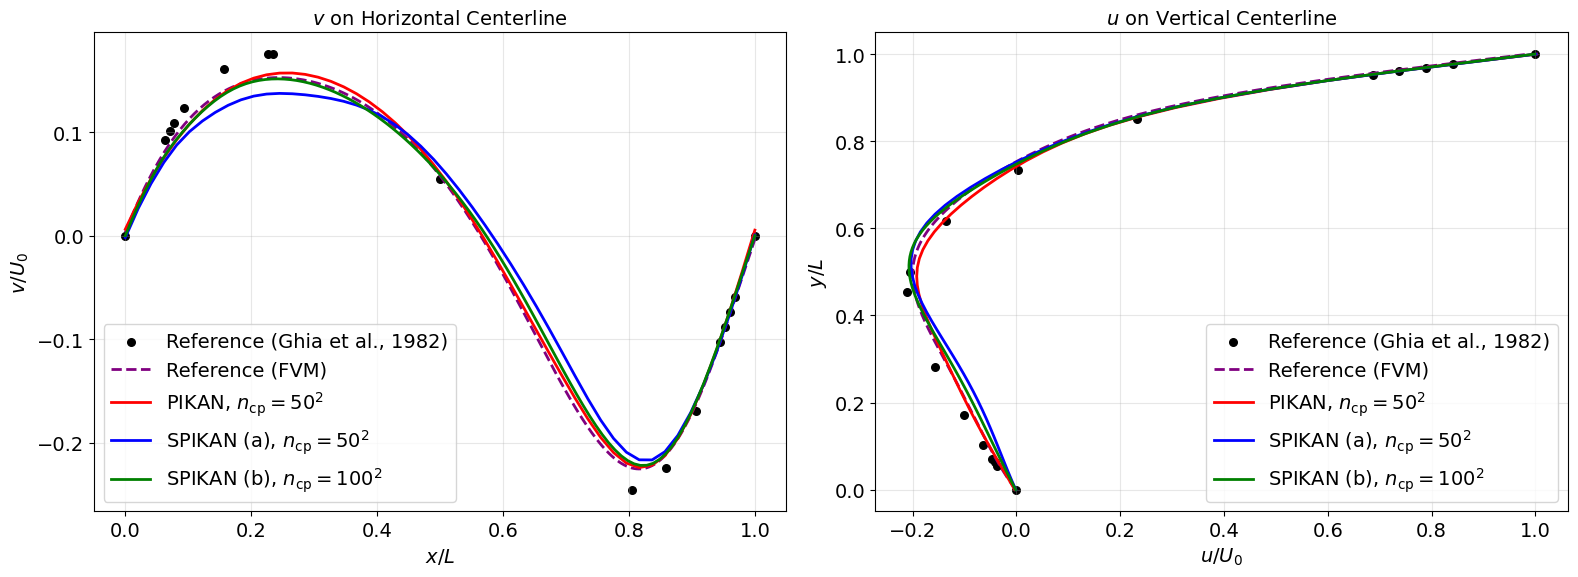

In [27]:

# Run the plot_centerline_comparison function with the new FVM reference data
plot_centerline_comparison(
    pikan_data_re100,
    spikan_data_re100_1,
    spikan_data_re100_2,
    reference_fvm_data_re100,
    Re=100,
    epochs=50000
)


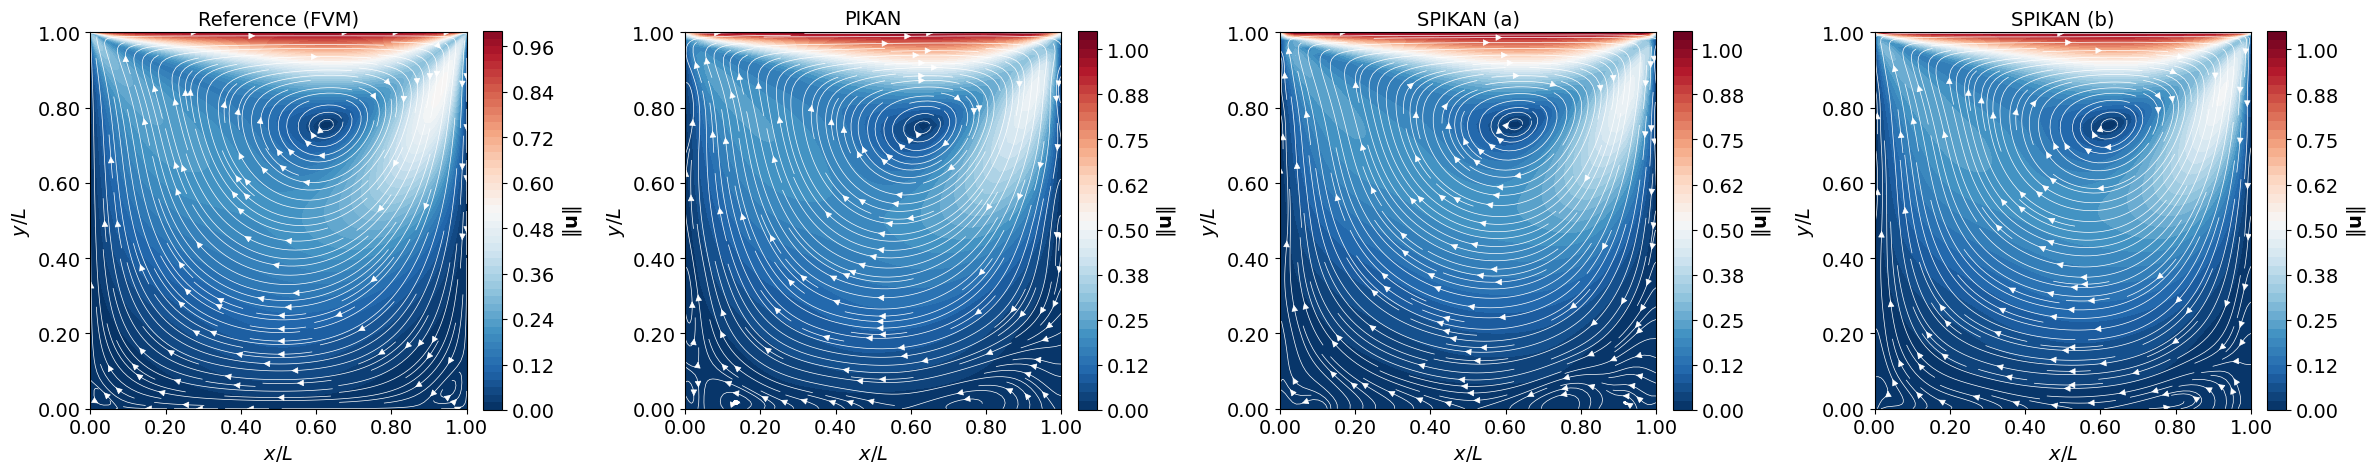

In [6]:

# Run the plot_field_comparison function
plot_field_comparison(
    pikan_data_re100,
    spikan_data_re100_1,
    spikan_data_re100_2,
    reference_fvm_data_re100,
    Re=100,
    epochs=50000
)


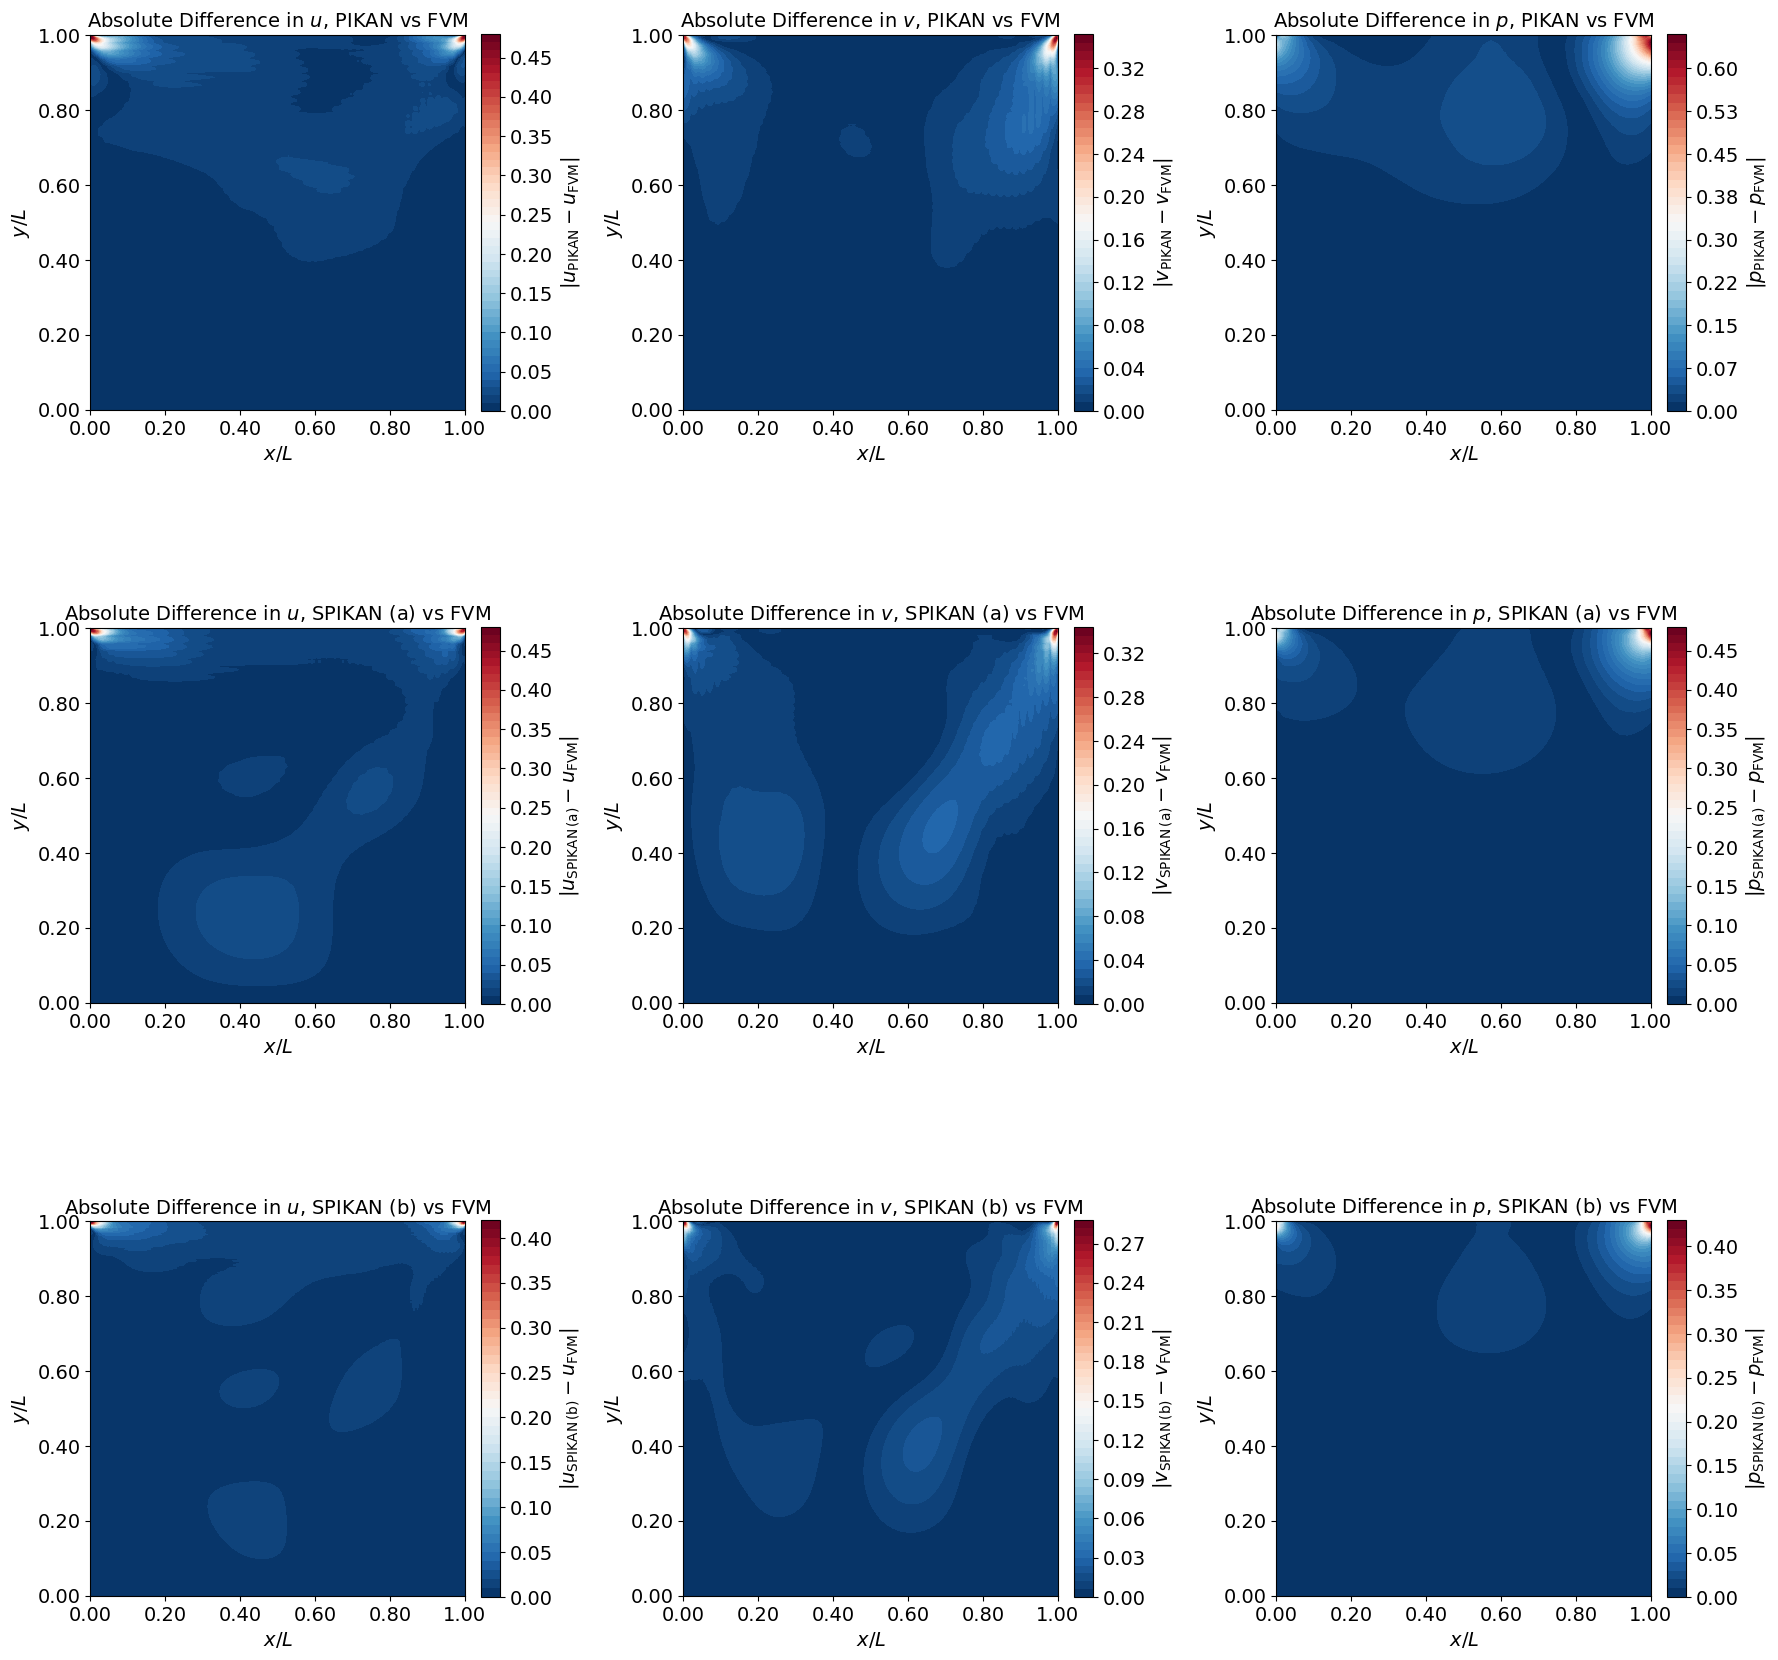

{'pikan': {'u': np.float64(9.736807948653627),
  'v': np.float64(11.797498799339596),
  'p': np.float64(48.716200785711536)},
 'spikan_a': {'u': np.float64(8.655919941645136),
  'v': np.float64(12.017360160266648),
  'p': np.float64(35.9177613695348)},
 'spikan_b': {'u': np.float64(5.829986976392016),
  'v': np.float64(7.183220873035196),
  'p': np.float64(29.545320326687936)}}

In [29]:

# Run the plot_absolute_error function
plot_absolute_difference(
    pikan_data_re100,
    spikan_data_re100_1,
    spikan_data_re100_2,
    reference_fvm_data_re100,
    Re=100,
    epochs=50000
)


